In [1]:
import sys
sys.path.insert(0, '../')
%reload_ext autoreload
%autoreload 2
import logging

In [2]:
import torch
from nowcasting.hko.dataloader import HKOIterator
from nowcasting.config import cfg

In [3]:
valid_hko_iter = HKOIterator(pd_path=cfg.HKO_PD.RAINY_VALID,
                                 sample_mode="sequent",
                                 seq_len=25,
                                 stride=5)

In [7]:
valid_hko_iter.reset()
valid_time = 0
while not valid_hko_iter.use_up:
    valid_batch, valid_mask, sample_datetimes, new_start =\
        valid_hko_iter.sample(batch_size=1)
    if valid_batch.shape[1] == 0:
        break
    valid_time += 1

In [8]:
valid_hko_iter.use_up

True

In [10]:
valid_hko_iter.reset()
valid_batch, valid_mask, sample_datetimes, new_start =\
    valid_hko_iter.sample(batch_size=1)

In [11]:
valid_batch.shape

(25, 1, 1, 480, 480)

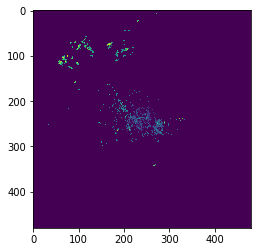

In [18]:
import matplotlib.pyplot as plt
plt.imshow(valid_batch[0, 0, 0, ...]/255.0)

In [17]:
import numpy as np
np.unique(valid_batch[0, 0, 0, ...])

array([  0,   2,   4,   5,   7,   9,  11,  13,  15,  16,  18,  20,  22,
        24,  26,  27,  29,  31,  33,  35,  36,  38,  40,  42,  44,  46,
        47,  49,  51,  53,  55,  56,  58,  60,  62,  64,  66,  67,  69,
        71,  73,  75,  77,  78,  80,  82,  84,  86,  87,  89,  91,  93,
        95,  97,  98, 100, 102, 104, 106, 107, 109, 111, 113, 115, 117,
       118, 120, 122, 124, 126, 128, 129, 131, 133, 135, 137, 138, 140,
       146], dtype=uint8)

In [19]:
from nowcasting.helpers.visualization import save_hko_gif, save_hko_movie

In [21]:
save_hko_movie(valid_batch[:, 0, 0, :, :],
                       sample_datetimes[0],
                       valid_mask[:, 0, 0, :, :],
                       masked=True,
                       save_path='1' + '.mp4')

Moviepy - Building video 1.mp4.
Moviepy - Writing video 1.mp4

Moviepy - Done !
Moviepy - video ready 1.mp4
